In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
model = HamiltonianMappingModel(input_dim=2, hidden_dim=128, num_layers=64)
model.flow

GsympNetFlow(
  (layers): ModuleList(
    (0-63): 64 x SymplecticCouplingLayer(
      (conditioner): GradientBasedConditioner()
    )
  )
)

In [67]:
n_actions = 1
n_angles = 1000
r_min = 0.5
r_max = 1.5
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=10, n_steps=n_angles, r_bounds=[r_min,r_max]) #

Text(0.5, 1.0, 'Toy Orbits')

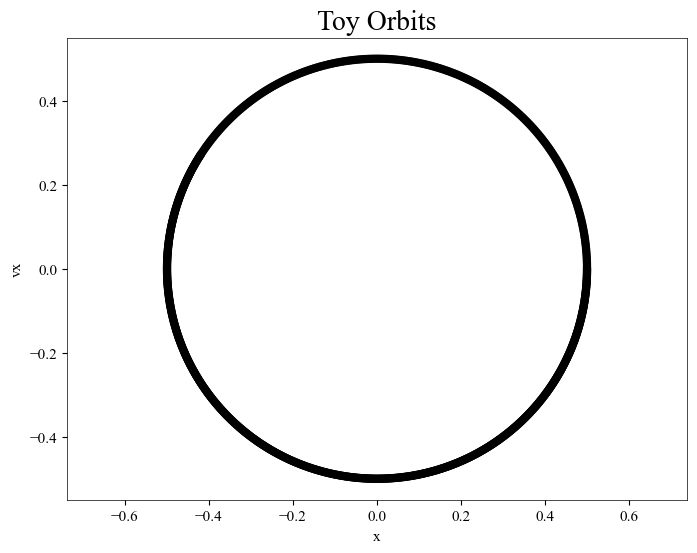

In [68]:
plt.scatter(*training_data.T)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

training: 1500 step with 5 orbits
1000 steps with 20 orbits

100%|██████████| 200/200 [00:12<00:00, 16.30it/s]


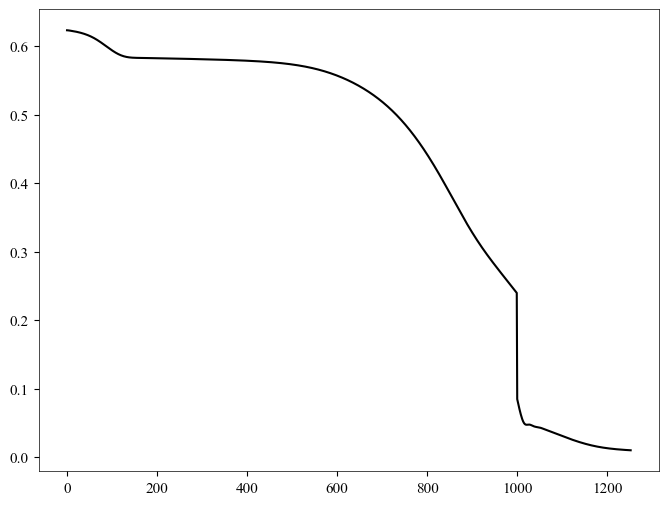

In [70]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

steps = 200
model.train(isoDiskPotential, training_data, steps)
plt.plot(model.loss_list)

In [71]:
ps_nf = model.aa_to_ps(aa_guess)

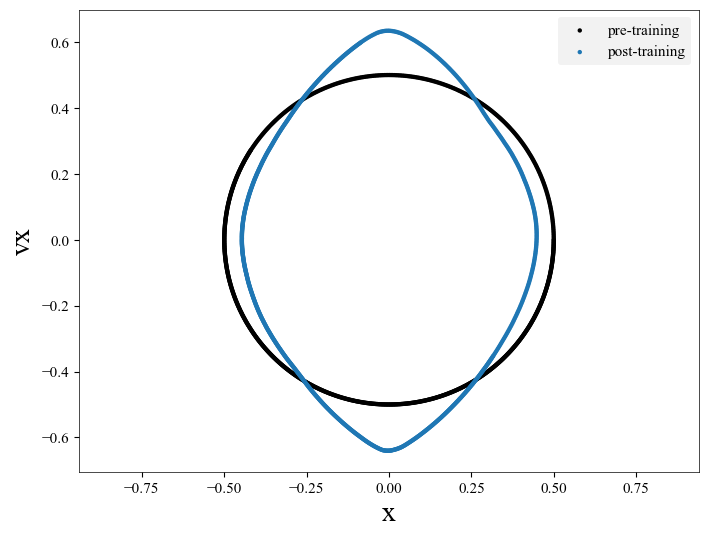

In [72]:
plt.scatter(*training_data.T.detach(), s=10, label='pre-training')
plt.scatter(*ps_nf.T.detach(), s=10, label='post-training')
plt.axis('equal')
plt.xlabel('x', fontsize=20)
plt.ylabel('vx', fontsize=20)
plt.legend()
plt.show()

In [73]:
from orbitflows import H

Text(0, 0.5, 'energy')

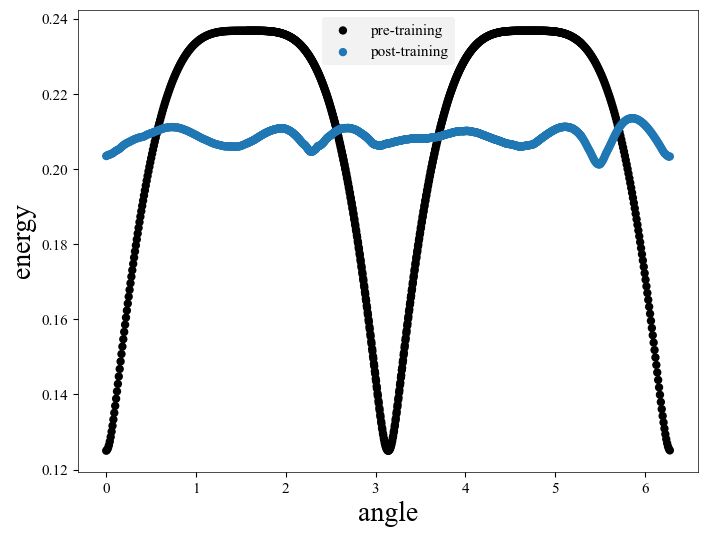

In [74]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)

Text(0, 0.5, 'H(J)')

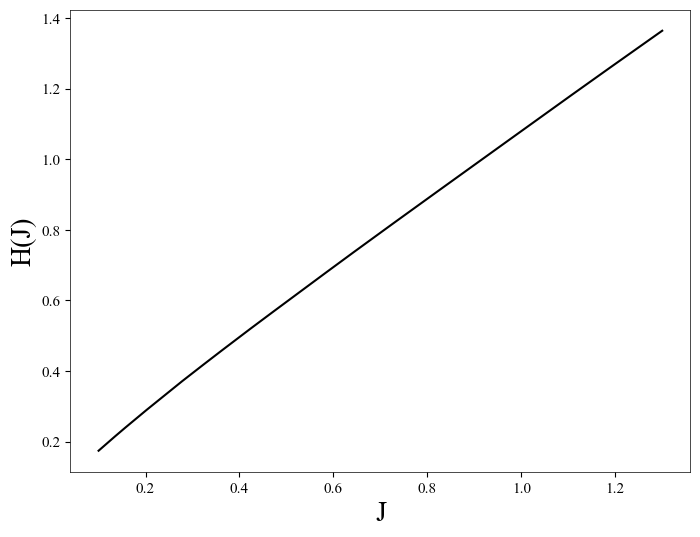

In [ ]:
# j_list = torch.linspace(0.1, 1.3, 1000, requires_grad=True)

# aa_list = torch.zeros((len(j_list), 2))
# aa_list[..., 1] = j_list
# h_list = model.hamiltonian(aa_list)
# plt.plot(j_list.detach(), h_list.detach())
# plt.xlabel('J', fontsize=20)
# plt.ylabel('H(J)', fontsize=20)

In [76]:
# model.frequency(aa_list)

In [77]:
freq_list = torch.zeros(len(j_list))
for i, aa in enumerate(aa_list):
    freq_list[i] = model.frequency(aa)

<>:3: SyntaxWarning: invalid escape sequence '\O'

<>:3: SyntaxWarning: invalid escape sequence '\O'

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_86949/1434531754.py:3: SyntaxWarning: invalid escape sequence '\O'
  plt.ylabel('$\Omega$(J)', fontsize=20)



Text(0, 0.5, '$\\Omega$(J)')

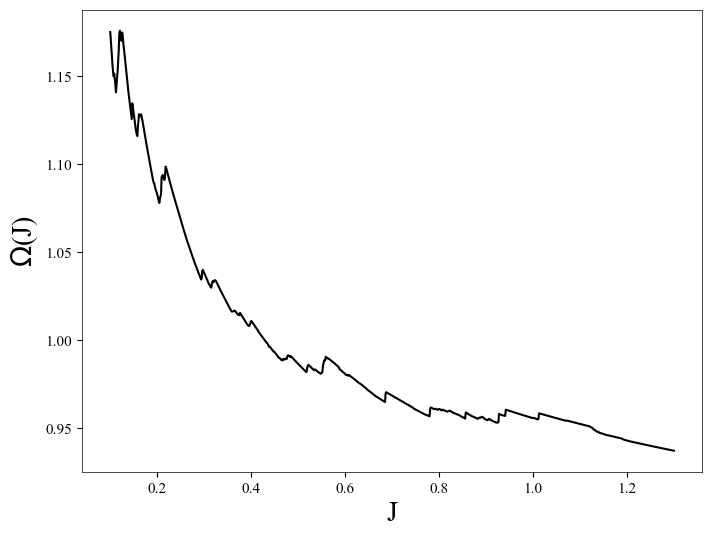

In [ ]:
# plt.plot(j_list.detach(), freq_list.detach())
# plt.xlabel('J', fontsize=20)
# plt.ylabel('$\Omega$(J)', fontsize=20)

In [128]:
def eulerstep(ps, delta_t, **kwargs):
    '''Euler step''' 
    q0 = ps[..., 0]
    p0 = ps[..., 1]
    p = p0 - delta_t * torch.autograd.grad(h_error(torch.stack([q0, p0], dim=-1), **kwargs), q0)[0]
    q = q0 + delta_t * torch.autograd.grad(h_error(torch.stack([q0, p0], dim=-1), **kwargs), p0)[0]
    return torch.stack([q, p], dim=-1)

In [131]:
def h_error(ps, H_tilde=hamiltonian_tilde, **kwargs):
    return H(ps, model.targetPotential) - hamiltonian_tilde(ps, **kwargs)

def hamiltonian_relative(aa, theta_set):
    _aa = aa.clone()
    _aa[..., 0] = theta_set.clone()
    return model.hamiltonian(_aa)

def frequency_relative(aa, theta_set):
    _aa = aa.clone()
    _aa[..., 0] = theta_set.clone()
    return model.frequency(_aa)

def hamiltonian_tilde(ps, theta_set):
    aa = model.ps_to_aa(ps)
    _aa = aa.clone()
    _aa[..., 0] = theta_set.clone()
    return model.hamiltonian(_aa)

In [132]:
from tqdm import tqdm

In [140]:
def integrate_with_correction(aa0, n_steps, t_end, correction_funct = eulerstep, **kwargs):
    '''Routine to integrate orbits in AA space and update frequencies regularly, with euler step correction
    
    Parameters
    ----------
    aa0 : torch.tensor
        initial action-angle variables
    steps_aa : int
        number of steps in action-angle space between frequency updates'''
    
    delta_t = torch.tensor(t_end/n_steps)
    theta_list = torch.zeros(n_steps)
    j_list = torch.zeros(n_steps)
    
    theta0 = aa0[...,0]
    j0 = aa0[...,1]
    freq = frequency_relative(aa, theta_set)
    

    for i, t in enumerate(tqdm(np.linspace(0, t_end, n_steps))):
        # evolve in action-angle space
        theta_half = theta0 + freq*delta_t/2 # drift 

        # transform to phase space
        aa_half = torch.stack((theta_half, j0))
        ps_half = model.aa_to_ps(aa_half)

        # compute Hamiltonian error

        ps_half_corrected = correction_funct(ps_half, delta_t, **kwargs)

        # convert back to action-angle space
        aa_half_corrected = model.ps_to_aa(ps_half_corrected)

        # update frequency
        theta_half_corrected = aa_half_corrected[0]
        j = aa_half_corrected[1]
        freq = frequency_relative(aa_half_corrected, theta_set)

        # drift
        theta = theta_half_corrected + freq*delta_t/2

        theta_list[i] = theta
        j_list[i] = j
        theta0 = theta
        j0 = j
        #print(theta0, J0)
    return torch.stack([theta_list, j_list], dim=-1)

In [141]:
dt = 0.01
aa = torch.tensor([0.0, 0.125], requires_grad=True)

In [142]:
aa_integrated = integrate_with_correction(aa, n_steps=100, t_end=1, theta_set = torch.tensor(0.0))


100%|██████████| 100/100 [00:04<00:00, 23.83it/s]


Text(0, 0.5, 'energy')

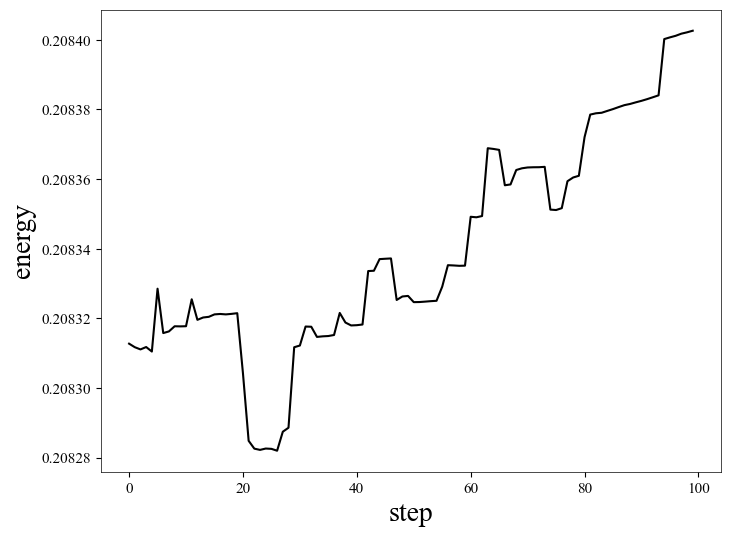

In [143]:
plt.plot(model.hamiltonian(aa_integrated).detach())
plt.xlabel('step', fontsize=20)
plt.ylabel('energy', fontsize=20)

100%|██████████| 100/100 [00:04<00:00, 23.48it/s]


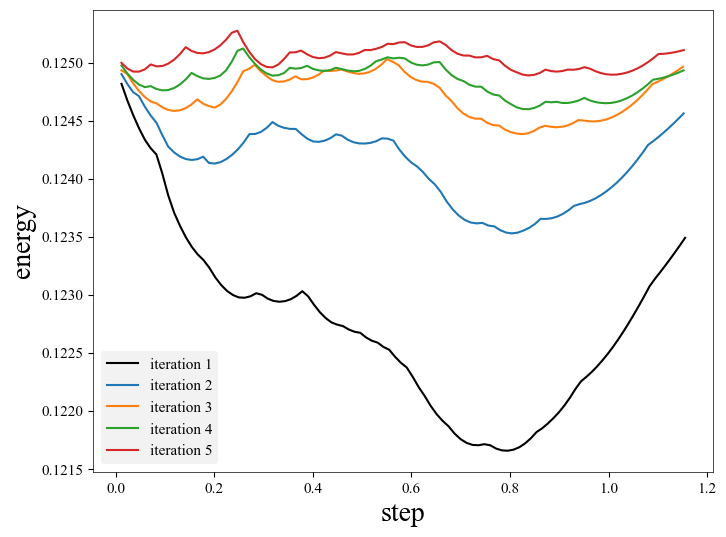

In [90]:
# check how integration improves after training more
for i in range(5):
    print(f'iteration {i}:')
    model.train(isoDiskPotential, training_data, 200)
    aa_integrated = integrate_with_correction(aa, n_steps=100, t_end=1)
    plt.plot(aa_integrated[:, 0].detach(), aa_integrated[:, 1].detach(), label=f'iteration {i+1}')
plt.xlabel('step', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend()
plt.show()


iteration 0:


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 23.70it/s]


iteration 1:


100%|██████████| 100/100 [00:04<00:00, 23.03it/s]


iteration 2:


100%|██████████| 1000/1000 [00:42<00:00, 23.48it/s]


iteration 3:


100%|██████████| 2000/2000 [01:23<00:00, 24.04it/s]


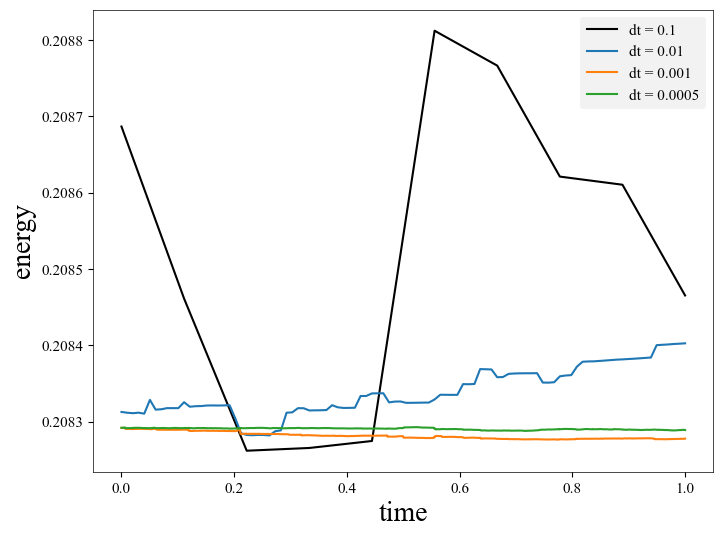

In [101]:
# check how changing time step improves after integration
t_end = 1
for i, dt in enumerate(np.array([0.1, 0.01, 0.001, 0.0005])):
    print(f'iteration {i}:')
    n_steps = int(t_end / dt)
    aa_integrated = integrate_with_correction(aa, n_steps=n_steps, t_end=t_end)
    plt.plot(np.linspace(0, 1, n_steps), model.hamiltonian(aa_integrated).detach(), label=f'dt = {dt}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend()
plt.show()

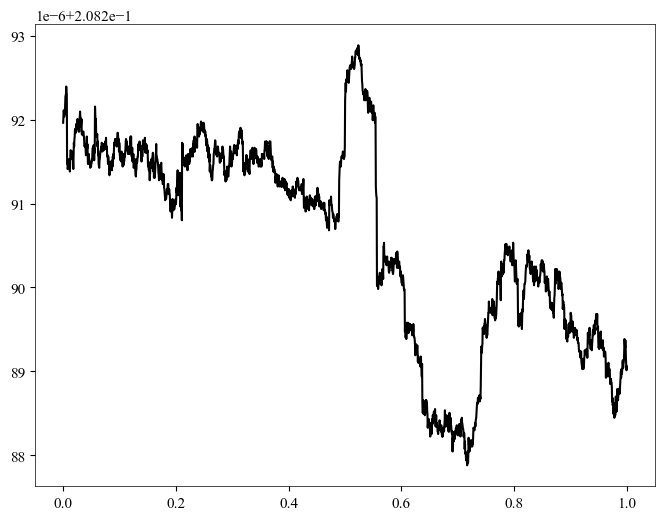

In [103]:
plt.plot(np.linspace(0, 1, n_steps), model.hamiltonian(aa_integrated).detach(), label=f'dt = {dt}')

Text(0, 0.5, 'energy')

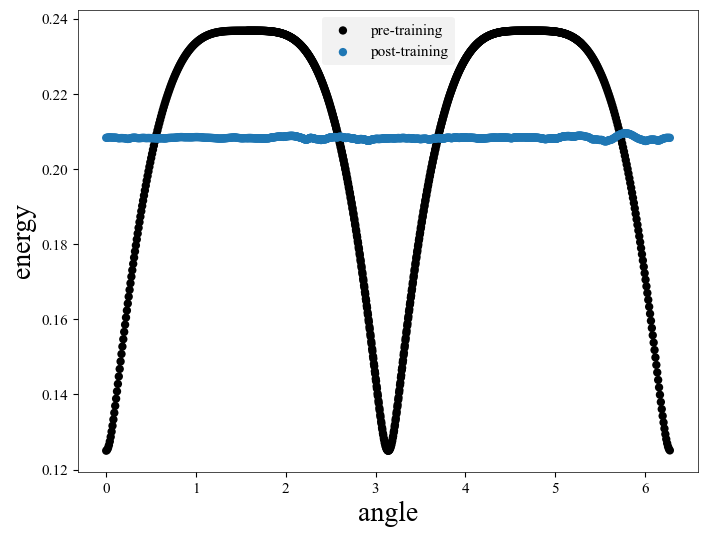

In [97]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)

You can also continuously train, if you want to fine tune the results, for example.

100%|██████████| 1000/1000 [01:00<00:00, 16.42it/s]


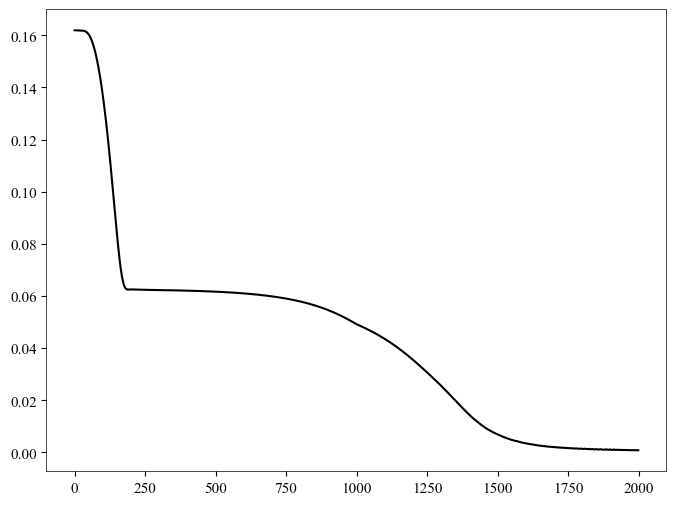

In [40]:
model.train(isoDiskPotential, training_data, steps)
plt.plot(model.loss_list)